# Pipeline

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from ml_metrics import rmsle
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GroupKFold

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def linear_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = abs(i - j) / float(num_ratings - 1)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            if i == j:
                d = 0.0
            else:
                d = 1.0
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = np.array(kappas, dtype=float)
    if weights is None:
        weights = np.ones(np.shape(kappas))
    else:
        weights = weights / np.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = np.array([min(x, .999) for x in kappas])
    kappas = np.array([max(x, -.999) for x in kappas])

    z = 0.5 * np.log((1 + kappas) / (1 - kappas)) * weights
    z = np.mean(z)
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def weighted_mean_quadratic_weighted_kappa(solution, submission):
    predicted_score = submission[submission.columns[-1]].copy()
    predicted_score.name = "predicted_score"
    if predicted_score.index[0] == 0:
        predicted_score = predicted_score[:len(solution)]
        predicted_score.index = solution.index
    combined = solution.join(predicted_score, how="left")
    groups = combined.groupby(by="essay_set")
    kappas = [quadratic_weighted_kappa(group[1]["essay_score"], group[1]["predicted_score"]) for group in groups]
    weights = [group[1]["essay_weight"].irow(0) for group in groups]
    return mean_quadratic_weighted_kappa(kappas, weights=weights)

In [8]:
def ae(actual, predicted):
    """
    Computes the absolute error.
    This function computes the absolute error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The absolute error between actual and predicted
    """
    return np.abs(np.array(actual)-np.array(predicted))

def ce(actual, predicted):
    """
    Computes the classification error.
    This function computes the classification error between two lists
    Parameters
    ----------
    actual : list
             A list of the true classes
    predicted : list
                A list of the predicted classes
    Returns
    -------
    score : double
            The classification error between actual and predicted
    """
    return (sum([1.0 for x,y in zip(actual,predicted) if x != y]) /
            len(actual))

def mae(actual, predicted):
    """
    Computes the mean absolute error.
    This function computes the mean absolute error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean absolute error between actual and predicted
    """
    return np.mean(ae(actual, predicted))

def mse(actual, predicted):
    """
    Computes the mean squared error.
    This function computes the mean squared error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean squared error between actual and predicted
    """
    return np.mean(se(actual, predicted))

def msle(actual, predicted):
    """
    Computes the mean squared log error.
    This function computes the mean squared log error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The mean squared log error between actual and predicted
    """
    return np.mean(sle(actual, predicted))

def rmse(actual, predicted):
    """
    Computes the root mean squared error.
    This function computes the root mean squared error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The root mean squared error between actual and predicted
    """
    return np.sqrt(mse(actual, predicted))

def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.
    This function computes the root mean squared log error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The root mean squared log error between actual and predicted
    """
    return np.sqrt(msle(actual, predicted))

def se(actual, predicted):
    """
    Computes the squared error.
    This function computes the squared error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The squared error between actual and predicted
    """
    return np.power(np.array(actual)-np.array(predicted), 2)

def sle(actual, predicted):
    """
    Computes the squared log error.
    This function computes the squared log error between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The squared log error between actual and predicted
    """
    return (np.power(np.log(np.array(actual)+1) - 
            np.log(np.array(predicted)+1), 2))

def ll(actual, predicted):
    """
    Computes the log likelihood.
    This function computes the log likelihood between two numbers,
    or for element between a pair of lists or numpy arrays.
    Parameters
    ----------
    actual : int, float, list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double or list of doubles
            The log likelihood error between actual and predicted
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    err = np.seterr(all='ignore')
    score = -(actual*np.log(predicted)+(1-actual)*np.log(1-predicted))
    np.seterr(divide=err['divide'], over=err['over'],
              under=err['under'], invalid=err['invalid'])
    if type(score)==np.ndarray:
        score[np.isnan(score)] = 0
    else:
        if np.isnan(score):
            score = 0
    return score

def log_loss(actual, predicted):
    """
    Computes the log loss.
    This function computes the log loss between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The log loss between actual and predicted
    """
    return np.mean(ll(actual, predicted))

In [4]:
df_train = pd.read_hdf('../input/train_bike.h5')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


## Dane
Wróćmy do zbioru, którego dotknęliśmy w module 4 - `Bike Sharing Demand`.

Zadaniem jest zrobienie predykcji popytu - ile rowerów powinno być na danej stacji dla danej godziny.

https://www.kaggle.com/c/bike-sharing-demand/data

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** -   
    1: Clear, Few clouds, Partly cloudy, Partly cloudy  
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

*Zwróć uwagę*, że `count = casual + registered`. To oznacza, że trzy kolumny są powiązane ze zmienną docelową i nie mogą być użyte podczas trenowania.

Sprawdźmy rozkład zmiennej docelowej.

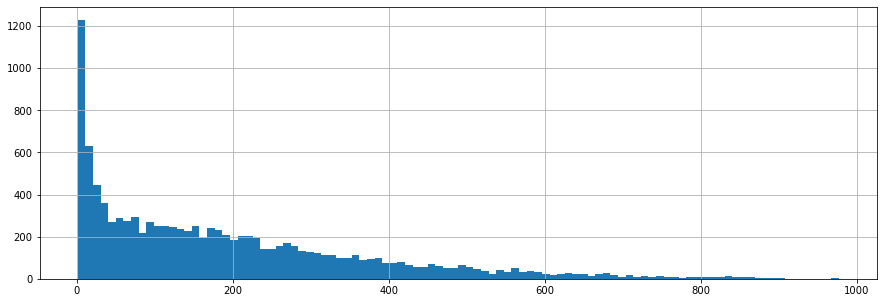

In [5]:
df_train['count'].hist(bins=100, figsize=(15, 5));

*Swoją drogą*, czy to dla Ciebie była niespodzianka, że rozkład z "popytem" będzie wyglądał na skrzywiony? 
Pewnie już wiesz, co chcemy z tym zrobić, ale na razie zostawmy tak jak jest.

Metryką sukcesu będzie **RMSLE** (która bardziej karze zaniżanie wyniku). W ramach przypomnienia poniżej wzór:

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

Zbudujmy najprostszy możliwy model.

## Basic Model

In [6]:
feats = df_train.select_dtypes(include=[np.int64, np.float64]).columns
feats = feats[ (feats != 'count') & (feats != 'registered') & (feats != 'casual') ]

X = df_train[feats].values
y = df_train['count'].values

In [9]:
models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median')),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = rmsle(y, y_pred)
    
    print(model_name, score)

dummy-mean 1.5691983019475926
dummy-median 1.4725894242962372


Teraz spróbujmy użyć drzewa decyzyjnego i lasów losowych.

*Zwróć uwagę*, że podaję `random_state`, żeby wynik był powtarzalny.

In [10]:
models = [
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=2019)),
    ('rf', RandomForestRegressor(max_depth=5, n_estimators=20, random_state=2019)),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = rmsle(y, y_pred)
    
    print(model_name, score)

dt 1.3345865242240684
rf 1.3325396672694263


Wynik jest trochę lepszy niż dla `dummy`, ale jest jeszcze nad czym popracować. W tej chwili w ogóle nie wykorzystujemy cechy `datetime`, więc coś z tym zaraz zrobimy.

Warto już również zacząć myśleć o tym, jak będziemy walidować rozwiązanie, bo cały czas trenujemy i testujemy na tym samym zbiorze.

In [11]:
df_train['datetime'] = pd.to_datetime( df_train['datetime'] )

df_train['hour'] = df_train['datetime'].dt.hour
df_train['day'] = df_train['datetime'].dt.day
df_train['month'] = df_train['datetime'].dt.month
df_train['year'] = df_train['datetime'].dt.year

Pojawiły się nowe cechy, więc trzeba jeszcze raz wczytać dane do `X`.

In [12]:
feats = df_train.select_dtypes(include=[np.int64, np.float64]).columns
feats = feats[ (feats != 'count') & (feats != 'registered') & (feats != 'casual') ]

X = df_train[feats].values
y = df_train['count'].values

In [13]:
models = [
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=2019)),
    ('rf', RandomForestRegressor(max_depth=5, n_estimators=20, random_state=2019)),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = rmsle(y, y_pred)
    
    print(model_name, score)

dt 0.6021408888997963
rf 0.5949945087320397


In [14]:
def custom_validation(data, feats, target_variable='count', n_folds=3):
    X = data[feats].values
    y = data[target_variable].values

    groups = data['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        
        
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return rmsle(y_test, y_pred)

In [15]:
for model_name, model in models:
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

Model: dt, scores-mean: 0.6209599748149964, scores-std: 0.012074654497161295
Model: rf, scores-mean: 0.6045477718222559, scores-std: 0.013652588538452191


## Feature engineering
Spróbujmy wygenerować jeszcze więcej cech.

In [16]:
df_train['dayofweek'] = df_train['datetime'].dt.dayofweek
df_train['weekofyear'] = df_train['datetime'].dt.weekofyear
df_train['weekend'] = df_train.dayofweek.map(lambda x: int(x in [5,6]) )

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_9436/1917838673.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['weekofyear'] = df_train['datetime'].dt.weekofyear


In [17]:
feats = df_train.select_dtypes(include=[np.int64, np.float64]).columns
feats = feats[ (feats != 'count') & (feats != 'registered') & (feats != 'casual') ]

X = df_train[feats].values
y = df_train['count'].values

In [18]:
for model_name, model in models:
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(df_train, feats):
        score = run_model(model, X_train, X_test, y_train, y_test)
        scores.append(score)
        
    print("Model: {0}, scores-mean: {1}, scores-std: {2}".format(model_name, np.mean(scores), np.std(scores)))

Model: dt, scores-mean: 0.6295266771184037, scores-std: 0.0162794568121357
Model: rf, scores-mean: 0.608049914962654, scores-std: 0.017740841432186828


Widać, że wynik jest porównywalny a nawet trochę gorszy... Również widać, że część kodu powtarza się. Mało tego, bardzo łatwo można się pogubić i odnotować, które cechy są stworzone i w którym miejscu. Dodatkowo, pamiętaj że dokładnie te same transformacje trzeba zrobić zarówno dla zbioru treningowego, jak i testowego.

Spróbujmy to uporządkować.

Możesz zauważyć, że przedtem zrobiliśmy kilka kroków:
1. Wczytanie danych.
2. Transformacja (wybranie odpowiednich kolumn i generowanie nowych).
3. Budowanie modelu.

To wszystko możemy podłączyć do `Pipeline`, które oczekuje na kroki działania. Warto teraz wspomnieć o dwóch rodzajach klas w `sklearn`:
- **Transformers** (posiada metody: `fit` i `transform`)
- **Estimators** (posiada metody: `fit` i `predict`)

`Pipeline` może zawierać jeden lub więcej `Transformer`ów, a ostatni krok to musi być `Estimator` lub innymi słowy model (np. `DecisionTreeRegressor` albo `RandomForestRegressor`).

Przykłady transformerów:
- [Label Encoder](https://bit.ly/3fobOst) - przypisanie ID dla każdej zmiennej kategorialnej,
- [Imputer](https://bit.ly/3uU31oX) - zarządzanie brakami danych,
- [SelectKBest](https://bit.ly/2RmOcg2) - wybór *k* najlepszych cech.

Możemy również zdefiniować własną klasę tak dla `Transformers`, jak i dla `Estimators`. Zrobienie własnej klasy, która transformuje dane w ten czy inny sposób, zdarza się znacznie częściej, niż tworzenie własnego modelu/estimatora.

Na początek zróbmy prosty przykład z modelem liniowym. Najpierw tak jak to robiliśmy dotychczas, a potem z użyciem `Pipeline`.

In [19]:
def train_and_predict(model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    y_pred[ y_pred < 0 ] =0
    return rmsle(y, y_pred)

In [20]:
feats = df_train.select_dtypes(include=[np.int64, np.float64]).columns
feats = feats[ (feats != 'count') & (feats != 'registered') & (feats != 'casual') ]

In [21]:
X = df_train[feats].values
y = df_train['count'].values

scalr = MinMaxScaler()
X = scalr.fit_transform(X)
model = LinearRegression()

train_and_predict(model, X, y)

1.2987262749693944

## Pipeline
To samo co wyżej tylko z `Pipeline`.

In [22]:
X = df_train[feats].values
y = df_train['count'].values

pipeline = Pipeline( [
    ('normalize', MinMaxScaler()),
    ('model', LinearRegression())
])

train_and_predict(pipeline, X, y)

1.2987262749693944

Również możemy dodać kod, który uzupełnia brakujące elementy używając `SimpleImputer`.

In [23]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('model', LinearRegression())
])

train_and_predict(pipeline, X, y)

1.2987262749693944

Zwróć uwagę, że teraz uruchamiamy `fit` i `predict` na `Pipeline` i tam w środku odbywa się cały łańcuch zmian. 

Idziemy dalej. Spróbujmy np. wybrać cechy, używając `VarianceThreshold`.

In [24]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('variance-treshold', VarianceThreshold(threshold=0.05)),
    ('model', LinearRegression())
])

train_and_predict(pipeline, X, y)

1.273889746042342

Również możemy użyć rekurencyjnego wybierania cech (pamiętaj, że to jest bardzo efektywna, ale wolna metoda).

In [25]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('variance-treshold', VarianceThreshold(threshold=0.05)),
    ('RFE', RFE(LinearRegression())),
    ('model', LinearRegression())
])

train_and_predict(pipeline, X, y)

1.272635499068297

To wrzućmy teraz bardziej złożony model np. `DecisionTreeRegressor`.

In [26]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('variance-treshold', VarianceThreshold(threshold=0.05)),
    ('model', DecisionTreeRegressor(max_depth=10))
])

train_and_predict(pipeline, X, y)

0.3323608160094821

A teraz `RandomForestRegressor`.

In [27]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('variance-treshold', VarianceThreshold(threshold=0.05)),
    ('model', RandomForestRegressor(max_depth=10, n_estimators=10))
])

train_and_predict(pipeline, X, y)

0.3251482035054004

Swoją drogą, masz również możliwość dostania się do każdego kroku `Pipeline` np. do modelu.

In [28]:
pipeline.named_steps['model']

RandomForestRegressor(max_depth=10, n_estimators=10)

Spróbujmy napisać własny `Transformer` (nie musisz rozumieć poniższego kodu).

In [29]:
class SelectFeature(TransformerMixin, BaseEstimator):
    def __init__(self, feature):
        self.feature = feature

    def fit(self, *_):
        return self
    
    def transform(self, data):
        return data[self.feature]

Można pójść dalej i zrobić własny ogólny `Transformer`.

In [30]:
class DFTransform(TransformerMixin, BaseEstimator):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy
        
    def fit(self, *_):
        return self

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)

Definiujemy funkcje, które wykorzystamy w naszym `Pipeline`.

In [31]:
def _remove_target_vars(df):
    feats = df.columns
    feats = feats[ (feats != 'count') & (feats != 'registered') & (feats != 'casual') ]
    
    return df[feats]

def _parse_date(df, feat):
    df[feat] = pd.to_datetime(df[feat])
    return df

def _extract_dt(df, feat):
    
    df['hour'] = df[feat].dt.hour
    df['day'] = df[feat].dt.day
    df['month'] = df[feat].dt.month
    df['year'] = df[feat].dt.year
    df['dayofweek'] = df[feat].dt.dayofweek
    df['weekofyear'] = df[feat].dt.weekofyear
    df['weekend'] = df.dayofweek.map(lambda x: int(x in [5,6]) )
    
    return df

Tworzymy `Pipeline` używając naszych funkcji.

In [32]:
pipeline = Pipeline([
    ('fill_na', DFTransform(lambda df: df.fillna(-1), copy=True) ),
    ('remove_target_var', DFTransform(_remove_target_vars) ),
    
    ('parse_date',  DFTransform(lambda df: _parse_date(df, 'datetime')) ),
    ('extract_dt', DFTransform(lambda df: _extract_dt(df, 'datetime')) ),
    
    ('numerical', Pipeline([
       ('select', DFTransform(lambda df: df.select_dtypes(include=['int'])) ), 
    ])),
    
    ('model', RandomForestRegressor(max_depth=10, n_estimators=10, random_state=2019) )
])

Teraz już dochodzimy do sedna, żeby zobaczyć wartość takiej "układanki". 

Wczytujemy zbiór treningowy, który posiada odpowiedź i zbiór testowy, który odpowiedzi nie ma. Przetwarzanie dla obu zbiorów będzie identyczne (zbiór testowy wprawdzie nie zawiera zmiennych docelowych, więc wykonanie na nim operacji usuwania tych zmiennych jest niepotrzebne, ale to nie przeszkadza, bo zachowujemy spójność `Pipeline`). 

Zobacz, jak łatwo wygląda teraz predykcja.

In [33]:
df_train = pd.read_hdf('../input/train_bike.h5')
df_test = pd.read_hdf('../input/test_bike.h5')

pipeline.fit(df_train, y)
y_pred = pipeline.predict(df_test)

y_pred

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_9436/3358762817.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df[feat].dt.weekofyear
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_9436/3358762817.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df[feat].dt.weekofyear


array([ 17.14978261,   6.60303533,   6.25903439, ..., 128.37424242,
       107.08570707,  74.84654611])

*Swoją drogą*, jeśli chodzi *serializację*, to teraz możesz zapisać na dysku całą logikę `Pipeline`. Mam nadzieje, że to już jest dla Ciebie oczywiste, jaką to daje przewagę w porównaniu do *serializacji* tylko "gołego" modelu. Pamiętaj tylko, że standardowy `pickle` nie poradzi sobie z `lambdami` (funkcje anonimowe), ale to już było omówione w poprzedniej lekcji.

## Przydatne linki:
1. [Deploying Machine Learning using sklearn pipelines](https://bit.ly/3uRHk93)
2. [Why you should use scikit-learn's Pipeline object](https://bit.ly/3olRb4h)
3. [Integrating Pandas and scikit-learn with pipelines](https://bit.ly/3eO53kG)
4. [Pandas, Pipelines, and Custom Transformers](https://bit.ly/3hvjAnd)